In [3]:
import numpy as np

In [116]:
count_data = np.genfromtxt(open('txtdata.csv'), dtype=float)
n_count_data = len(count_data) 
print(count_data)

[22. 70. 59.  8. 83. 89. 82. 77. 16. 56. 94. 75. 28. 72. 50. 70. 43. 89.
 62. 14. 69. 83. 78. 39. 25.  7. 69. 86. 80. 48. 36. 82. 17. 51. 35. 35.
 85. 96. 18. 65. 71.  7. 22. 72. 33. 85. 56. 93. 16. 39. 84. 20. 13.  6.
 36.  9. 76. 84. 32. 41. 65. 85. 97. 31. 53. 10. 39.  9. 78. 55. 42. 61.
 11. 57. 50. 13. 62.  4. 88.  9. 83. 23. 32. 88. 10. 50. 94. 10. 72. 85.
 74.  7. 62. 97. 40. 69. 45. 12.  2. 25. 91. 80. 19. 91. 77. 53. 99. 44.
 74. 37. 83. 57. 13. 29. 67. 54. 91. 79. 10.  1. 59. 68. 71. 76. 85. 15.
 53. 10. 58. 55.  2. 16. 23. 23. 38. 80. 58. 58.  3. 10. 40. 10. 20. 46.
 88. 98. 55. 28. 11. 73. 22. 43. 83. 41. 11. 91. 30. 85. 20. 41. 68. 46.
 74. 42. 77. 77. 63. 23. 36. 76. 44.  5. 17.  1. 85. 92. 92. 57. 46. 82.
 85. 99. 23. 19. 16. 74. 86. 55. 80. 58. 10. 54. 79. 46. 58. 18. 82. 18.
 85. 22. 47. 49. 42. 55. 85. 47. 40. 71. 13. 15.  6. 87. 58. 42. 82. 23.
 56. 69. 20. 57. 83. 94. 93. 45.  6. 46. 68. 20. 33. 92. 74. 97. 68.  2.
 40. 83. 70. 18. 32. 74. 17. 45. 16. 85. 18. 99. 13

(0, 412)

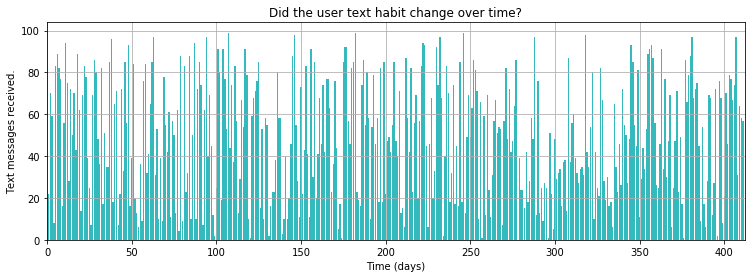

In [112]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12.5,4))
colors = ['#34BABD', '#A60628']
plt.bar(np.arange(n_count_data), count_data, color=colors[0])
plt.grid(True)
plt.xlabel('Time (days)')
plt.ylabel('Text messages received.')
plt.title('Did the user text habit change over time?')
plt.xlim(0, n_count_data)

In [117]:
count_data.mean()

48.98783454987834

In [130]:
import pymc as pm
pm.__version__

alpha = 1.0/count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

In [144]:
mcmc = pm.MCMC(model)
mcmc.sample(50000, 10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 10.7 sec

In [145]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

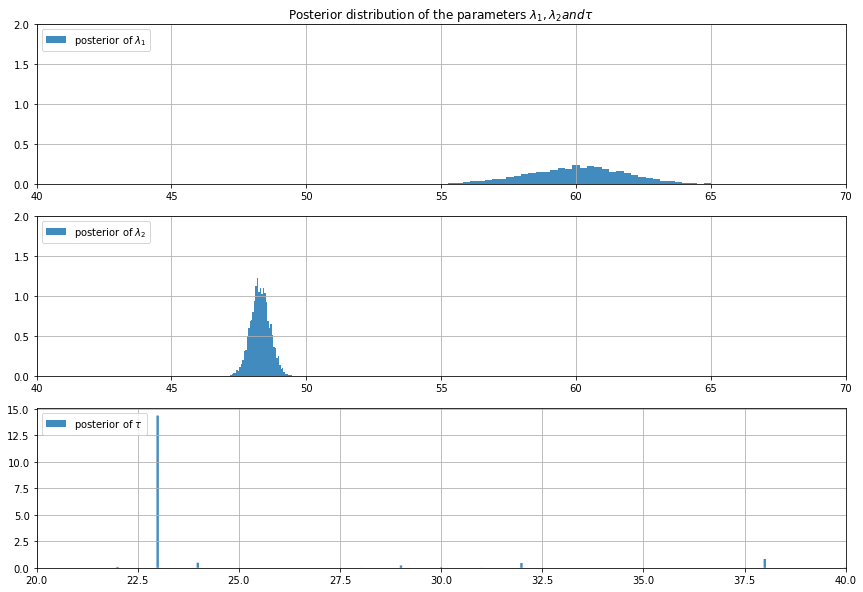

In [146]:
fig = plt.figure(figsize=(14.5, 10))
ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, label="posterior of $ \lambda_1 $", 
         histtype='stepfilled', bins=50, alpha=0.85, normed=True)
plt.grid(True)
plt.xlim([40,70])
plt.ylim([0,2])
plt.title("Posterior distribution of the parameters $ \lambda_1, \lambda_2 and \\tau $")
plt.legend(loc='upper left')

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, label="posterior of $ \lambda_2 $", 
         histtype='stepfilled', bins=50, alpha=0.85, normed=True)
plt.grid(True)
plt.xlim([40,70])
plt.ylim([0,2])
plt.legend(loc='upper left')

ax = plt.subplot(313)
w = 1.0/tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, label="posterior of $ \\tau $", 
         histtype='stepfilled', bins=n_count_data, alpha=0.85, normed=True, weights=w, rwidth=.2)
plt.grid(True)
plt.xlim([20,40])
plt.legend(loc='upper left')

No handles with labels found to put in legend.


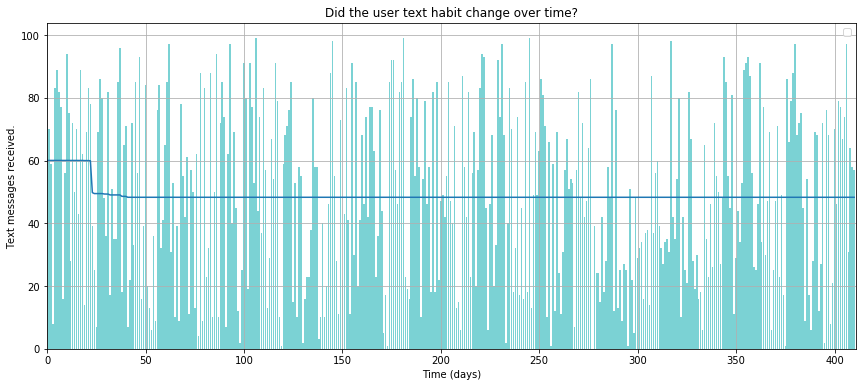

In [147]:
fig = plt.figure(figsize=(14.5, 6))
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)

for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum())/N 
    
colors = ['#34BABD', '#A60628']

plt.plot(range(n_count_data), expected_texts_per_day)
plt.bar(np.arange(n_count_data), count_data, color=colors[0], alpha=0.65)
plt.grid(True)
plt.xlabel('Time (days)')
plt.ylabel('Text messages received.')
plt.title('Did the user text habit change over time?')
plt.xlim(0, n_count_data)
plt.legend()

In [135]:
print(expected_texts_per_day)

[60.31285581 60.31285581 60.31285581 60.31285581 60.31285581 60.31285581
 60.31285581 60.31285581 60.31285581 60.31285581 60.31285581 60.31285581
 60.31285581 60.31285581 60.31285581 60.31285581 60.31285581 60.31285581
 60.31285581 60.29818568 60.29818568 60.29757236 60.22798971 48.88900911
 48.5316944  48.53096891 48.53096891 48.53096891 48.53096891 48.50196797
 48.49353246 48.49292062 48.43343887 48.43290238 48.43290238 48.43290238
 48.43290238 48.43290238 48.33649439 48.33649439 48.33561657 48.30744535
 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535
 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535
 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535
 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535
 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535
 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535 48.30744535
 48.30744535 48.30744535 48.30744535 48.30744535 48